# Detecting Bursty Terms in Computer Science Research Using Text Mining

**E. Tattershall, G. Nenadic, R.D. Stevens**

**Abstract**

Research topics rise and fall in popularity over time, some more swiftly than others. The fastest rising topics are typically called *bursts*; e.g. `deep learning`, `internet of things` and `big data`. Being able to detect and track bursty terms in the literature could give insight into how scientific thought evolves over time.


In this paper, we take a trend detection algorithm from technical stock market analysis and apply it to 31 years of computer science research abstracts, treating the prevalence of each term in the dataset like the price of a stock. Unlike previous work in this domain, we use the free text of abstracts and titles, resulting in a finer-grained analysis. We report a list of bursty terms, then use historical data to build a classifier to predict whether they will rise or fall in popularity in the future, obtaining accuracy in the region of 80%. As a consequence, we now have a pipeline that can be applied to any time-ordered collection of text to yield past and present bursty terms and predict their probable fate.

**Data collection**

- We downloaded data from DBLP (api:, alternative= semantic scholar)
- Automatically detected and labelled non-English language abstracts using: 
- Unpacked into MySQL database


In [81]:
%matplotlib inline

# Visualisation
import matplotlib.pyplot as plt

# database
import _mysql

# monitoring
import time

# data cleaning
import re

# lemmatisation
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# intermediate storage
import csv
import pandas as pd
import pickle

# stats
import numpy as np

# stopwords
from nltk.corpus import stopwords

# Clustering
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

# Machine learning
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

### Choice of parameters

In [134]:
ngram_length = 3
min_yearly_df = 5

long_ma_length = 12
short_ma_length = 6
signal_line_ma = 3
significance_ma_length = 3

significance_threshold = 0.0002
years_above_significance = 3
testing_period = 3

# Detection threshold is set such that the top 500 terms are chosen
burstiness_threshold_prediction = 0.003
burstiness_threshold_detection = 0.002451

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rc('font', family='sans-serif')

year_range = list(range(1988,2018))

### Functions

In [76]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
htmltags = '<[^>]+>'
htmlspecial = '&#?[xX]?[a-zA-Z0-9]{2,8};'

start_delimiter = 'documentstart'
sent_delimiter = 'sentenceboundary'
end_delimiter = 'documentend'

delimiters = [start_delimiter, sent_delimiter, end_delimiter]

# Download the lemmatisesr
wnl = WordNetLemmatizer()

# Create a tokeniser
count = CountVectorizer(strip_accents='ascii', min_df=1)
tokeniser = count.build_analyzer()

def normalise_acronymns(text):
    '''
    Remove the periods in acronyms. 
    Adapted from the method found at https://stackoverflow.com/a/40197005 
    '''
    return re.sub(r'(?<!\w)([A-Z, a-z])\.', r'\1', text)

def normalise_decimals(text):
    '''
    Remove the periods in decimal numbers and replace with POINT
    '''
    return re.sub(r'([0-9])\.([0-9])', r'\1POINT\2', text)

def split_into_sentences(text):
    '''
    Sentence splitter adapted from https://stackoverflow.com/a/31505798
    '''
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    
    # my addition
    text = re.sub(htmltags, " ", text)
    text = re.sub(htmlspecial, " ", text)
    
    if "Ph.D" in text: 
        text = text.replace("Ph.D.","PhD")
        
    text = re.sub("\s" + alphabets + "[.] "," \\1",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1\\2\\3",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1\\2",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1 \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1",text)
    text = re.sub(" " + alphabets + "[.]"," \\1",text)
    
    if "”" in text: 
        text = text.replace(".”","”.")
    if "\"" in text: 
        text = text.replace(".\"","\".")
    if "!" in text: 
        text = text.replace("!\"","\"!")
    if "?" in text: 
        text = text.replace("?\"","\"?")
        
    text = text.replace(".","<stop>")
    text = text.replace("?","<stop>")
    text = text.replace("!","<stop>")
    
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    
    non_empty = []
    for s in sentences: 
        # we require that there be two alphanumeric characters in a row
        if len(re.findall("[A-Za-z0-9][A-Za-z0-9]", s)) > 0:
            non_empty.append(s)
    return non_empty

def pad_sentences(sentences):
    '''
    Takes a list of sentences and returns a string in which:
        - The beginning of the abstract is indicated by DOCUMENTSTART
        - The end is indicated by DOCUMENTEND
        - Sentence boundaries are indicated by SENTENCEBOUNDARY
        
    The number of delimiters used is dependent on the ngram length
    '''
    sent_string = (' '+(sent_delimiter+' ')*(ngram_length-1)).join(sentences)
    
    return (start_delimiter+' ')*(ngram_length-1) + sent_string + (' '+end_delimiter)*(ngram_length-1)
    
def cleaning_pipeline(title, abstract):
    '''
    Takes a binary string and returns a list of cleaned sentences, stripped of punctuation and lemmatised
    '''

    title = normalise_decimals(normalise_acronymns(title.decode()))
    abstract = normalise_decimals(normalise_acronymns(abstract.decode()))
    sentences = [title] + split_into_sentences(abstract)
    
    # strip out punctuation and make lowercase
    clean_sentences = []
    for s in sentences:
        
        # Deal with special cases
        s = re.sub(r'[-/]', ' ', s)
        
        # Remove all other punctuation
        s = re.sub(r'[^\w\s]','',s)
                   
        clean_sentences.append(s.lower())
        
    # pad sentences with delimiters
    text = pad_sentences(clean_sentences)
    
    # Lemmatise word by word
    lemmas = []
    for word in tokeniser(text):
        lemmas.append(wnl.lemmatize(word))
        
    return ' '.join(lemmas)


def calc_macd(dataset):
    long_ma = dataset.ewm(span=long_ma_length).mean()
    short_ma = dataset.ewm(span=short_ma_length).mean()
    significance_ma = dataset.ewm(span=significance_ma_length).mean()
    macd = short_ma - long_ma
    signal = macd.ewm(span=signal_line_ma).mean()
    hist = macd - signal
    return long_ma, short_ma, significance_ma, macd, signal, hist

def calc_significance(stacked_vectors, significance_threshold, n):
    # Must have been above the significance threshold for two consecutive timesteps
    a = stacked_vectors>significance_threshold
    b = a.rolling(window=n).sum()
    return stacked_vectors[stacked_vectors.axes[1][np.where(b.max()>=n)[0]]]
    
def calc_burstiness(hist, scaling_factor):
    return hist.iloc[long_ma_length-1:]/scaling_factor

def calc_scaling(significance_ma, method):
    if method == "max":
        scaling = significance_ma.iloc[significance_ma_length-1:].max()
    elif method == "mean":
        scaling = significance_ma.iloc[significance_ma_length-1:].mean()
    elif method == "sqrt":
        scaling = np.sqrt(significance_ma.iloc[significance_ma_length-1:].max()  )      
    return scaling

def max_burstiness(burstiness, absolute=False):
    if absolute:
        b = pd.concat([np.abs(burstiness).max(), burstiness.idxmax()], axis=1)
    else:
        b = pd.concat([burstiness.max(), burstiness.idxmax()], axis=1)
    b.columns = ["max", "location"]
    return b

def feature_selection(dataset):
    '''
    Compile the features for the prediction step
    '''
    long_ma = dataset.ewm(span=long_ma_length).mean()
    short_ma = dataset.ewm(span=short_ma_length).mean()
    significance_ma = dataset.ewm(span=significance_ma_length).mean()
    macd = short_ma - long_ma
    signal = macd.ewm(span=signal_line_ma).mean()
    hist = macd - signal
    
    scaling_factor = calc_scaling(significance_ma, "sqrt")
    burstiness_over_time = calc_burstiness(hist, scaling_factor)
    burstiness = max_burstiness(burstiness_over_time)
    
    
    X = long_ma.iloc[long_ma_length:].T
    scaled_hist = hist.iloc[long_ma_length:]/scaling_factor
    scaled_signal = signal.iloc[long_ma_length:]/scaling_factor
    
    Xtra = pd.concat([significance_ma.iloc[-1], 
                      dataset.iloc[-1],
                        significance_ma.iloc[significance_ma_length:].std()/scaling_factor,
                        significance_ma.iloc[significance_ma_length:].max(),
                        significance_ma.iloc[significance_ma_length:].min(),
                      scaling_factor
                        ], axis=1)
    X = pd.concat([X,scaled_hist.T,scaled_signal.T,Xtra], axis=1)

    X.columns = [str(i) for i in range(8)] + ["hist"+str(i) for i in range(8)] + ["signal"+str(i) for i in range(8)] + [
                        "significance",
                        "prevalence",
                        "scaled std",
                        "max",
                        "min",
                        "scaling"
                    ]


    return X

def balanced_subsample(x,y,subsample_size=1.0):
    # from https://stackoverflow.com/a/23479973
    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

### Some statistics about the dataset

In [4]:
db=_mysql.connect(user="root",passwd="",db="dblp")

There are 2634308 total English-language documents in the dataset.


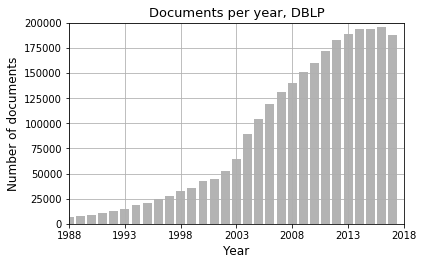

In [5]:
# Create a frequency distribution of English-language documents over time
db.query("""SELECT year, COUNT(*) as count FROM dblp2018 where `language`='en\r' GROUP BY year ORDER BY year ASC;""")
r=db.store_result()

results = r.fetch_row(maxrows=0)
number_of_documents = [int(r[1]) for r in results[:-1]]
years = [d[0] for d in results[:-1]]

# Plot a figure
fig = plt.figure(figsize=(6,3.7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Documents per year, DBLP', fontsize=13)
ax.grid()
ax.set_ylim(0,200000)
ax.set_xlim(0,30)
ax.set_ylabel('Number of documents',fontsize=12)
ax.set_xlabel('Year',fontsize=12)
plt.xticks(np.arange(0,31,5), np.arange(1988,2019, 5))
ax.bar(years, number_of_documents, color='0.7', label = 'All')

print("There are", str(np.sum(number_of_documents)), "total English-language documents in the dataset.")

### The average length of titles and abstracts

Text(0.5,0,'Year')

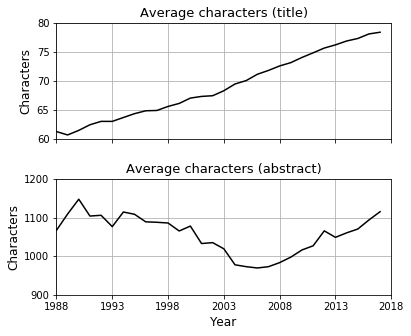

In [6]:
db.query("""SELECT year, AVG(CHAR_LENGTH(title)), AVG(CHAR_LENGTH(abstract)) as count FROM dblp2018 where `language`='en\r' GROUP BY year ORDER BY year ASC;""")
r=db.store_result()

results = r.fetch_row(maxrows=0)

x = np.arange(0,len(results)-1)
titles = [float(d[1]) for d in results[:-1]]
abstracts = [float(d[2]) for d in results[:-1]]

fig, ax = plt.subplots(2, figsize=(6,5), sharex=True)
plt.subplots_adjust(hspace=0.35)
ax[0].set_title('Average characters (title)', fontsize=13)
ax[0].plot(x, titles, color='k', ls='-', label='titles')
ax[0].grid()
ax[0].set_ylim(60,80)
ax[0].set_xlim(0,30)
ax[0].set_ylabel('Characters', fontsize=12)

plt.xticks(np.arange(0,31,5), np.arange(1988,2019, 5))
ax[1].set_title('Average characters (abstract)', fontsize=13)
ax[1].plot(x, abstracts, color='k', ls='-', label='abstracts')
ax[1].grid()
ax[1].set_ylim(900,1200)
ax[1].set_ylabel('Characters', fontsize=12)
ax[1].set_xlabel('Year', fontsize=12)

## Vectorisation

Prior to this section, we took the MySQL data and cleaned it in another notebook (not included here because of the time taken to run). The procedure can be seen in cleaning_pipeline() above, but essentially it involved:
- Normalising decimals so that 3.7 -> 3POINT7
- Normalising acronyms so that e.g. I.O.P -> IOP
- Splitting the abstract into individual sentences
- Tokenising each sentence individually.
- Lemmatising each token
- Adding sentence delimeters around every sentence, and between the title and abstract. This is to ensure we do not take bi- and tri-grams across sentence boundaries.

### Stopword list

- We use the normal set of nltk stopwords, the numbers 0-9 and 00-99, the years 1900-2018, and a limited set of words that we found not to be information-bearing in this context.

In [8]:
stop = set(stopwords.words('english'))
stop = set([s.replace("'", "") for s in stop])

# Add years to prevent spikes
for year in range(1900, 2020):
    stop.add(str(year))

# Add small numbers
for num in range(0, 100):
    if len(str(num)) < 2:
        stop.add(str(num))
        num = '0' + str(num)
        
    stop.add(str(num))
    
# Add these extra stopwords to the list
extra = [
    'use', 'using', 'uses', 'used', 'based', 'including', 'include', 'approach',
    'wa', 'ha', 'doe'
        ]
for word in extra:
    stop.add(word)


## Build a vocabulary

We have to build a vocabulary before we vectorise the data. This is because we want to set limits on the size of the vocabulary. 
- Terms must occur at least 5 times in at least one year. This removes one-off spelling errors or excessively rare terms, which, given the intended application, are not interesting to us. 
- We take uni, bi and tri-grams.
- We use sentence delimeters to avoid taking bi and tri-grams across sentence boundaries.


In [9]:
vocab = set()
for year in range(1988, 2018):
    df = pd.read_csv('../Data/clean_dblp/'+str(year)+'.csv')
    
    # The same as above, applied year by year instead.
    t0 = time.time()

    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,ngram_length),
                                 stop_words=stop,
                                 min_df=min_yearly_df)


    vector = vectorizer.fit_transform(df.text)
    
    # Save the new words
    vocab = vocab.union(vectorizer.vocabulary_.keys())
    
    print(year, len(vocab), time.time()-t0)

    
vocabulary = {}
i = 0
for v in vocab:
    # Remove delimiters
    if start_delimiter in v:
        pass
    elif end_delimiter in v:
        pass
    elif sent_delimiter in v:
        pass
    else:
        vocabulary[v] = i
        i += 1
        
print(len(vocabulary.keys()))

1988 25692 7.088000059127808
1989 36158 8.603999853134155
1990 46820 10.743000030517578
1991 56281 11.759999990463257
1992 68189 14.794000148773193
1993 81635 17.29900026321411
1994 100108 21.322999954223633
1995 117463 23.680999994277954
1996 138159 27.778000116348267
1997 161417 31.77900004386902
1998 188912 37.187000036239624
1999 216216 40.180999994277954
2000 252081 48.967000246047974
2001 282932 49.81699991226196
2002 323207 58.06400012969971
2003 376940 71.08799982070923
2004 469382 96.4670000076294
2005 565754 111.91100025177002
2006 668303 130.1399998664856
2007 768343 140.99608254432678
2008 865812 154.2474229335785
2009 967271 169.29692792892456
2010 1068816 182.70226860046387
2011 1178349 201.63316130638123
2012 1297239 213.95323753356934
2013 1402657 224.0695059299469
2014 1505240 232.78116989135742
2015 1598581 236.857754945755
2016 1693630 245.8268904685974
2017 1779048 239.97552156448364
1517518


## Go year by year and vectorise based on our vocabulary

We read in the cleaned data and vectorise it according to our vocabulary.

In [10]:
vectors = []
for year in range(1988, 2018):
    df = pd.read_csv('../Data/clean_dblp/'+str(year)+'.csv')
    
    # The same as above, applied year by year instead.
    t0 = time.time()


    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,ngram_length),
                                 stop_words=stop,
                                 vocabulary=vocabulary)


    vectors.append(vectorizer.fit_transform(df.text))
    
    print(year, time.time()-t0)
    

1988 6.552000045776367
1989 3.755999803543091
1990 4.317000150680542
1991 4.894000053405762
1992 5.67799973487854
1993 6.521999835968018
1994 8.523000001907349
1995 8.95199990272522
1996 11.531000137329102
1997 13.475000143051147
1998 14.690999984741211
1999 15.930999994277954
2000 19.12000012397766
2001 19.521000146865845
2002 22.30299997329712
2003 29.24575710296631
2004 39.14782786369324
2005 46.920382261276245
2006 52.79055619239807
2007 57.3664710521698
2008 58.569711685180664
2009 63.28699445724487
2010 67.35873508453369
2011 74.34443378448486
2012 83.90738987922668
2013 81.94519376754761
2014 85.83658289909363
2015 86.40463948249817
2016 88.78687787055969
2017 86.73267245292664


## Summing the vectors

We sum the vectors along columns, so that we have the popularity of each term in each year.

- All >1 elements are set to 1. This is because it does not matter for our application if a word is used multiple times in an abstract.
- We divide by the number of documents in each year to normalise the score. Therefore, the 1988 column is divided by ~6000, etc

In [11]:
summed_vectors = []

for y in range(len(vectors)):
    vector = vectors[y]

    # Set all elements that are greater than one to one -- we do not care if a word is used multiple times in 
    # the same document
    vector[vector>1] = 1

    # Sum the vector along columns
    summed = np.squeeze(np.asarray(np.sum(vector, axis=0)))

    # Normalise by dividing by the number of documents in that year
    normalised = summed/vector.shape[0]
    
    # Save the summed vector
    summed_vectors.append(normalised)
    
# Stack vectors vertically, so that we have the full history of popularity/time for each term
stacked_vectors = np.stack(summed_vectors, axis=1)

print(stacked_vectors.shape)

stacked_vectors=pd.DataFrame(stacked_vectors.transpose(), columns=list(vocabulary.keys())) 

(1517518, 30)


In [108]:
stacked_vectors = pickle.load(open('../Data/methods_paper/stacked_vectors.p', "rb"))
burstvectors = pickle.load(open('../Data/methods_paper_2/burstvectors_500.p', "rb"))

### Normalise the vectors again

The number of tokens per abstract has changed over time. We now normalise again, so each year sums to 100.

In [109]:
normalisation = stacked_vectors.sum(axis=1)
stacked_vectors = stacked_vectors.divide(normalisation, axis='index')*100

### Apply a significance threshold
We require that each term has been above a given significance threshold for 3 years. This shortens the vocabulary and removes single year spikes due to anomalous events.

In [111]:
stacked_vectors = calc_significance(stacked_vectors, significance_threshold, years_above_significance)
print(stacked_vectors.shape)

(30, 70159)


## Calculate burstiness

In [97]:
long_ma, short_ma, significance_ma, macd, signal, hist = calc_macd(stacked_vectors)
scaling_factor = calc_scaling(significance_ma, "sqrt")
burstiness_over_time = calc_burstiness(hist, scaling_factor)
burstiness = max_burstiness(burstiness_over_time)

### Set a threshold such that the top 500 bursty terms are included

In [98]:
print(np.sum(burstiness["max"]>0.002451))

500


In [104]:
bursts = list(burstiness["max"].index[np.where(burstiness["max"]>burstiness_threshold_detection)[0]])
print(bursts)

['service oriented architecture', '0point18 spl', 'expression data', 'content', 'fifth', 'feature map', 'acm subject', 'soa', 'may purchased', 'show proposed', 'crowdsourcing', 'periodical', 'result show', 'http www', '5g', 'eciency', 'version document may', 'elsevier', 'big', 'massive', 'reserved', 'article history received', 'software defined', 'available http github', 'owl', 'router', 'task', 'wireless mesh network', 'learning', 'relay', 'spl time', 'print electronic form', 'mu cmos', 'cognitive radio network', 'camid4v1 title', '978', 'button product webpage', 'journal economic', 'product librarian', 'selection peer', 'elsevier inc right', 'rfid', 'classification number', 'science bv right', 'avc', 'technology', 'wsn', 'differentiated service', 'simulation result', 'mmwave', 'state art method', 'summary form given', 'deep learning model', 'webpage www', 'efficient', 'smart city', 'web service', 'journal infosci', 'elsevier ltd', 'neural', 'antenna', 'copyright john wiley', 'igi', '

## Cluster bursts based on co-occurence

We cluster our 500 bursts based on their co-occurence in abstracts

In [23]:
# vectorise again, using these terms only
vectors = []
for year in range(1988, 2018):
    df = pd.read_csv('../Data/clean_dblp/'+str(year)+'.csv')
    
    # The same as above, applied year by year instead.
    t0 = time.time()


    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 ngram_range=(1,ngram_length),
                                 stop_words=stop,
                                 vocabulary=bursts)

    vector = vectorizer.fit_transform(df.text)
    
    # If any element is larger than one, set it to one
    vector.data = np.where(vector.data>0, 1, 0)
    
    vectors.append(vector)
    
    print(year, time.time()-t0)

1988 2.632999897003174
1989 2.5250000953674316
1990 3.003000259399414
1991 3.1740002632141113
1992 3.803999900817871
1993 4.730000019073486
1994 5.771000146865845
1995 6.111999988555908
1996 7.129999876022339
1997 8.062000274658203
1998 9.735000133514404
1999 10.58299994468689
2000 12.434000015258789
2001 12.904000043869019
2002 15.089000225067139
2003 18.10099983215332
2004 24.506999969482422
2005 28.425999879837036
2006 32.45631647109985
2007 35.766576051712036
2008 38.98089790344238
2009 42.290228605270386
2010 45.26152586936951
2011 49.26992678642273
2012 54.476447105407715
2013 55.44154381752014
2014 57.87278652191162
2015 58.20781993865967
2016 59.57795715332031
2017 58.15581488609314


In [24]:
cooccurrence = []
for v in vectors:
    c = v.T*v
    c.setdiag(0)
    c = c.todense()
    cooccurrence.append(c)
    
all_cooccurrence = np.sum(cooccurrence, axis=0)

# Translate co-occurence into a distance
dists = 1- all_cooccurrence/all_cooccurrence.max()

# Remove the diagonal (squareform requires diagonals be zero)
dists -= np.diag(np.diagonal(dists))

# Put the distance matrix into the format required by hierachy.linkage
flat_dists = squareform(dists)

# Get the linkage matrix
linkage_matrix = hierarchy.linkage(flat_dists, "ward")

assignments = hierarchy.fcluster(linkage_matrix, 80, 'maxclust')
print(len(bursts))
print(len(set(assignments)))

clusters = defaultdict(list)

for term, assign in zip(bursts, assignments):
    clusters[assign].append(term)
    
for key in sorted(clusters.keys()):
    print(key, ':',  ', '.join(clusters[key]))

C:\Users\tattere\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


500
80
1 : state art, art, state
2 : network, efficient, propose, different, proposed, novel, paper propose, task
3 : simulation, result show, show proposed, simulation result
4 : social, social network
5 : web, online, service, technology, content, internet
6 : security, attack
7 : device, mobile
8 : significant, energy, efficiency
9 : neural network, neural
10 : machine learning, machine, learning
11 : wireless sensor, node, wireless, sensor network, wireless sensor network, sensor
12 : hoc network, ad hoc, ad hoc network, ad, hoc
13 : title available, product webpage, purchased add cart, com article, available full version, document may, global com article, page available, may purchased add, product webpage www, camid4v1 title available, infosci journal discipline, available infosci, document may purchased, version document may, button, librarian www, title available infosci, purchased add, available full, cart button, webpage, infosci journal, camid4v1 title, journal infosci journa

## Graph selected bursty terms over time

We manually remove clusters that contain copyright declarations, etc. Then we filter down to 52, choosing a representative sample over time. We choose one or two terms to represent each cluster.

In [105]:
df = pd.read_csv('clusters3/clusters.csv')
clusters = [d.split(', ') for d in df.terms]

In [106]:
clusters

[['neural network'],
 ['intranet'],
 ['virtual reality', 'vr'],
 ['data warehouse'],
 ['commerce'],
 ['java'],
 ['xml'],
 ['internet'],
 ['router'],
 ['grid computing'],
 ['peer peer', 'p2p'],
 ['semantic web'],
 ['data mining'],
 ['owl'],
 ['mobile ad hoc', 'manet'],
 ['gene expression'],
 ['service oriented architecture', 'soa'],
 ['bluetooth'],
 ['security'],
 ['web 2point0'],
 ['wireless sensor network'],
 ['particle swarm optimization'],
 ['multicore', 'multi core'],
 ['gpu'],
 ['social network'],
 ['cognitive radio'],
 ['smart grid'],
 ['kinect'],
 ['smartphones', 'smartphone'],
 ['cloud'],
 ['dataset', 'datasets'],
 ['machine learning'],
 ['wearable'],
 ['crowdsourcing'],
 ['long short term', 'lstm'],
 ['github'],
 ['big data'],
 ['spark'],
 ['deep'],
 ['iot', 'internet thing'],
 ['ar iv'],
 ['recurrent neural network', 'rnn'],
 ['representation learning'],
 ['autoencoder'],
 ['mmwave', 'millimeter wave'],
 ['word embeddings', 'word embedding'],
 ['convolutional neural', 'cnn'],

Text(0,0.5,'Percentage of documents containing term (%)')

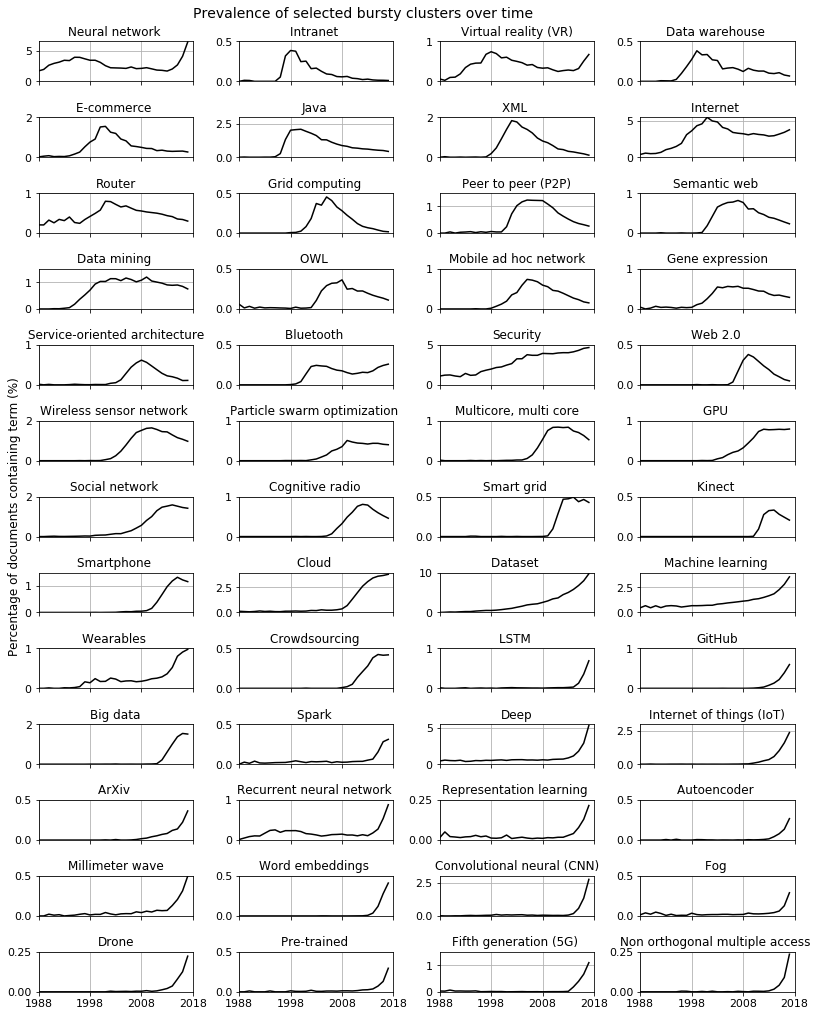

In [112]:
def get_prevalence(cluster):
    indices = []
    for term in cluster:
        indices.append(bursts.index(term))

    prevalence = []
    for year in range(30):
        prevalence.append(100*np.sum(np.sum(burstvectors[year][:,indices], axis=1)>0)/burstvectors[year].shape[0])
        
    return prevalence


yplots = 13
xplots = 4
fig, axs = plt.subplots(yplots, xplots)
plt.subplots_adjust(right=1, hspace=0.9, wspace=0.3)
plt.suptitle('Prevalence of selected bursty clusters over time', fontsize=14)
fig.subplots_adjust(top=0.95)
fig.set_figheight(16)
fig.set_figwidth(12)
x = np.arange(0,30)

prevalences = []
for i, cluster in enumerate(clusters):
    prevalence = get_prevalence(cluster)
    prevalences.append(prevalence)
    title = df.name[i]
    axs[int(np.floor((i/xplots)%yplots)), i%xplots].plot(x, prevalence, color='k', ls='-', label=title)
    axs[int(np.floor((i/xplots)%yplots)), i%xplots].grid()
    ymax=np.ceil(max(prevalence)*2)/2
    if ymax == 0.5 and max(prevalence) <0.25:
        ymax=0.25
    elif ymax == 2.5:
        ymax=3
    axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_ylim(0,ymax)
    axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_xlim(0,30)
    axs[int(np.floor((i/xplots)%yplots)), i%xplots].set_title(title, fontsize=12)
    
    
    if i%yplots != yplots-1:
        axs[i%yplots, int(np.floor((i/yplots)%xplots))].set_xticklabels([])
    else:
        axs[i%yplots, int(np.floor((i/yplots)%xplots))].set_xticklabels([1988, 1998, 2008, 2018])
        
axs[6,0].set_ylabel('Percentage of documents containing term (%)', fontsize=12)


## Prediction

### Build the development set

In [113]:
development_data = {}
for year in range(2008, 2018):
    year_idx = year_range.index(year)
    
    # Use our three-year method to calc significance
    valid_vectors = calc_significance(stacked_vectors[:year_idx+1], significance_threshold, 3)
    
    # Recalculate the macd things based on this more limited dataset
    long_ma, short_ma, significance_ma, macd, signal, hist = calc_macd(valid_vectors)
    
    
    # Calculate scaling factor
    scaling_factor = calc_scaling(significance_ma.iloc[max(long_ma_length, year_idx-19):year_idx+1], "sqrt")

    # Calculate the burstiness
    burstiness_over_time = calc_burstiness(hist, scaling_factor)
    burstiness = max_burstiness(burstiness_over_time)

    # Choose terms that are above both thresholds (burstiness, and also most recent year was significant)
    burst_idx = np.where((burstiness["max"]>0.0012)&(significance_ma.iloc[year_idx]>significance_threshold))[0]
    
    # Find the actual names of these terms
    bursts = valid_vectors.keys()[burst_idx]
    
    # Create a new, much smaller dataset
    dataset = stacked_vectors[bursts].iloc[year_idx-19:year_idx+1]
    
    # Get the scaled y values
    if year < 2015:
        y = stacked_vectors[bursts].iloc[year_idx+testing_period]


    # Select features and store the data
    development_data[year] = {}
    development_data[year]["X"] = feature_selection(dataset)
    if year < 2015:
        development_data[year]["y"]=y-development_data[year]["X"]['significance']
    print(year, len(bursts))

2008 1881
2009 1946
2010 1969
2011 2067
2012 2190
2013 2152
2014 2273
2015 2255
2016 2369
2017 2535


### Choosing a max depth for the random forest

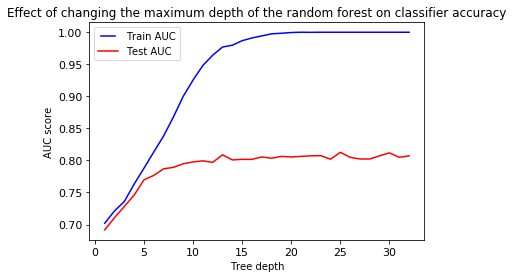

In [114]:
X = np.array(pd.concat([development_data[year]["X"] for year in range(2008,2015)]))
y = np.array(pd.concat([development_data[year]["y"] for year in range(2008,2015)]))
y_thresh = np.zeros_like(y)
y_thresh[y>0] = 1

# Balance the sample
X, y_thresh = balanced_subsample(X, y_thresh,subsample_size=1.0)
x_train, x_test, y_train, y_test = train_test_split(X, y_thresh, test_size=0.33, random_state=1)

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)


line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('Effect of changing the maximum depth of the random forest on classifier accuracy')
plt.show()

### Choosing the number of estimators

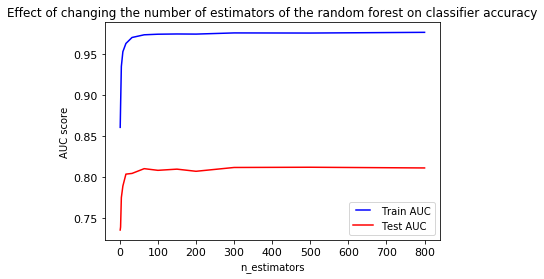

In [115]:
X = np.array(pd.concat([development_data[year]["X"] for year in range(2008,2015)]))
y = np.array(pd.concat([development_data[year]["y"] for year in range(2008,2015)]))
y_thresh = np.zeros_like(y)
y_thresh[y>0] = 1

# Balance the sample
X, y_thresh = balanced_subsample(X, y_thresh,subsample_size=1.0)
x_train, x_test, y_train, y_test = train_test_split(X, y_thresh, test_size=0.33, random_state=3)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300, 500, 800]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, max_depth=13, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.title('Effect of changing the number of estimators of the random forest on classifier accuracy')
plt.show()

## The effect of changing the burstiness threshold and prediction interval on the random forest classifier

In [116]:
scores = {}
for threshold in np.arange(0.0006, 0.0017, 0.0002):
    scores[threshold] = {}
    for year in range(2008, 2013):
        year_idx = year_range.index(year)

        # Use our three-year method to calc significance
        valid_vectors = calc_significance(stacked_vectors[:year_idx+1], significance_threshold, 3)

        # Recalculate the macd things based on this more limited dataset
        long_ma, short_ma, significance_ma, macd, signal, hist = calc_macd(valid_vectors)


        # Calculate scaling factor
        scaling_factor = calc_scaling(significance_ma.iloc[max(long_ma_length, year_idx-19):year_idx+1], "sqrt")

        # Calculate the burstiness
        burstiness_over_time = calc_burstiness(hist, scaling_factor)
        burstiness = max_burstiness(burstiness_over_time)

        # Choose terms that are above both thresholds (burstiness, and also most recent year was significant)
        burst_idx = np.where((burstiness["max"]>threshold)&(significance_ma.iloc[year_idx]>significance_threshold))[0]

        # Find the actual names of these terms
        bursts = valid_vectors.keys()[burst_idx]

        # Create a new, much smaller dataset
        dataset = stacked_vectors[bursts].iloc[year_idx-19:year_idx+1]

        # Select features and store the data
        development_data[year] = {}
        development_data[year]["X"] = feature_selection(dataset)
        
        development_data[year]["y"] = {}
        
        for interval in range(1,6):
            # Get the scaled y values
            y = stacked_vectors[bursts].iloc[year_idx+interval]
            development_data[year]["y"][interval]=y-development_data[year]["X"]['significance']
    
    
    X = np.array(pd.concat([development_data[year]["X"] for year in range(2008,2013)]))
    
    for interval in range(1,6):
        scores[threshold][interval] = {}
        scores[threshold][interval]['scores'] = []
        y = np.array(pd.concat([development_data[year]["y"][interval] for year in range(2008,2013)]))
        
        # Binarise y data
        y_thresh = np.zeros_like(y)
        y_thresh[y>0] = 1
        
        # Balance the sample
        X_bal, y_thresh = balanced_subsample(X, y_thresh,subsample_size=1.0)
        
        scores[threshold][interval]['size'] = len(y_thresh)
        kf = KFold(n_splits=10, shuffle=True)
        for train, test in kf.split(X_bal):
            clf = RandomForestClassifier(n_estimators=150, max_depth=13)

            clf.fit(X_bal[train], y_thresh[train])
            preds = clf.predict(X_bal[test])

            new_scores = [
                sklearn.metrics.accuracy_score(y_thresh[test], preds),
                sklearn.metrics.f1_score(y_thresh[test], preds),
                np.sum(y_thresh[test]==0)/len(y_thresh[test])
            ]
            scores[threshold][interval]['scores'].append(new_scores)
        
        print(threshold, interval, len(y_thresh), np.round(np.mean(np.array(scores[threshold][interval]['scores'])[:,0]),3)
             )


0.0006 1 60448 0.683
0.0006 2 58156 0.705
0.0006 3 56136 0.714
0.0006 4 54880 0.722
0.0006 5 52894 0.722
0.0007999999999999999 1 28394 0.729
0.0007999999999999999 2 26886 0.744
0.0007999999999999999 3 25570 0.748
0.0007999999999999999 4 24804 0.752
0.0007999999999999999 5 23858 0.752
0.001 1 14518 0.766
0.001 2 13572 0.776
0.001 3 12978 0.789
0.001 4 12604 0.784
0.001 5 12142 0.783
0.0012 1 8358 0.805
0.0012 2 7808 0.816
0.0012 3 7450 0.815
0.0012 4 7254 0.82
0.0012 5 6962 0.817
0.0013999999999999998 1 5594 0.814
0.0013999999999999998 2 5150 0.823
0.0013999999999999998 3 4886 0.822
0.0013999999999999998 4 4772 0.824
0.0013999999999999998 5 4622 0.809
0.0015999999999999999 1 3852 0.837
0.0015999999999999999 2 3524 0.843
0.0015999999999999999 3 3332 0.835
0.0015999999999999999 4 3256 0.824
0.0015999999999999999 5 3156 0.826


### Format for table in paper

In [125]:
for threshold in np.arange(0.0006, 0.0017, 0.0002):
    print(threshold, '&', 
          scores[threshold][3]['size'], '&', 
          np.round(np.mean(np.array(scores[threshold][3]['scores'])[:,0]),2), 
          '$\pm$', 
          np.round(np.std(np.array(scores[threshold][3]['scores'])[:,0]),2), '&', 
          np.round(np.mean(np.array(scores[threshold][3]['scores'])[:,1]),2), 
          '$\pm$', 
          np.round(np.std(np.array(scores[threshold][3]['scores'])[:,1]),2), 
          '\\\\'
         )

0.0006 & 56136 & 0.71 $\pm$ 0.01 & 0.72 $\pm$ 0.01 \\
0.0007999999999999999 & 25570 & 0.75 $\pm$ 0.01 & 0.75 $\pm$ 0.01 \\
0.001 & 12978 & 0.79 $\pm$ 0.01 & 0.79 $\pm$ 0.01 \\
0.0012 & 7450 & 0.82 $\pm$ 0.01 & 0.82 $\pm$ 0.01 \\
0.0013999999999999998 & 4886 & 0.82 $\pm$ 0.02 & 0.83 $\pm$ 0.02 \\
0.0015999999999999999 & 3332 & 0.83 $\pm$ 0.02 & 0.84 $\pm$ 0.02 \\


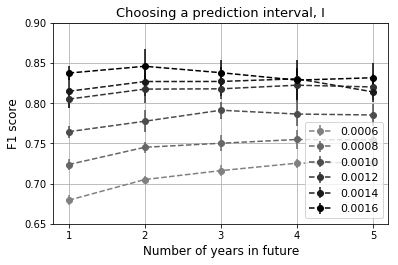

In [126]:
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
line_styles = ['-', '--', ':']
col = 0.5
fig = plt.figure(figsize=(6,3.7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Choosing a prediction interval, I', fontsize=13)
ax.grid()
ax.set_ylim(0.65,0.9)
#ax.set_xlim(1,5)

ax.set_ylabel('F1 score', fontsize=12)
ax.set_xlabel('Number of years in future', fontsize=12)

plt.xticks(range(1,6), range(1,6))

thresholds = ["0.0006", "0.0008", "0.0010", "0.0012", "0.0014", "0.0016"]
for i, threshold in enumerate(np.arange(0.0006, 0.0017, 0.0002)):
    y = []
    yerr = []
    for interval in range(1,6):
        s = np.array(scores[threshold][interval]['scores'])
        y.append(np.mean(s[:,1]))
        yerr.append(np.std(s[:,1]))
    
    ax.errorbar(range(1,6), y, yerr=yerr, color=str(col),  label=thresholds[i], fmt='--o')
        
    col-=0.1
    
#ax.legend(ncol=3, mode="expand")
ax.legend(fontsize=11)

## Train a single classifier on all the data from 1988-2014

In [127]:
threshold = 0.0012
interval = 3

for year in range(2008, 2018):
    year_idx = year_range.index(year)

    # Use our three-year method to calc significance
    valid_vectors = calc_significance(stacked_vectors[:year_idx+1], significance_threshold, 3)

    # Recalculate the macd things based on this more limited dataset
    long_ma, short_ma, significance_ma, macd, signal, hist = calc_macd(valid_vectors)


    # Calculate scaling factor
    scaling_factor = calc_scaling(significance_ma.iloc[max(long_ma_length, year_idx-19):year_idx+1], "sqrt")

    # Calculate the burstiness
    burstiness_over_time = calc_burstiness(hist, scaling_factor)
    burstiness = max_burstiness(burstiness_over_time)

    # Choose terms that are above both thresholds (burstiness, and also most recent year was significant)
    burst_idx = np.where((burstiness["max"]>threshold)&(significance_ma.iloc[year_idx]>significance_threshold))[0]

    # Find the actual names of these terms
    bursts = valid_vectors.keys()[burst_idx]

    # Create a new, much smaller dataset
    dataset = stacked_vectors[bursts].iloc[year_idx-19:year_idx+1]

    # Select features and store the data
    development_data[year] = {}
    development_data[year]["X"] = feature_selection(dataset)
    if year < 2015:
        y = stacked_vectors[bursts].iloc[year_idx+interval]
        development_data[year]["y"]=y-development_data[year]["X"]['significance']


X = np.array(pd.concat([development_data[year]["X"] for year in range(2008,2015)]))
y = np.array(pd.concat([development_data[year]["y"] for year in range(2008,2015)]))

# Binarise y data
y_thresh = np.zeros_like(y)
y_thresh[y>0] = 1

# Balance the sample
X_bal, y_thresh = balanced_subsample(X, y_thresh,subsample_size=1.0)


clf = RandomForestClassifier(n_estimators=150, max_depth=13)
clf.fit(X_bal, y_thresh)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Choose all terms that were above the burstiness and significance thresholds in 2017

In [135]:
# Choose terms that are above both thresholds
burst_idx = np.where((burstiness["max"]>burstiness_threshold_prediction)&(significance_ma.iloc[29]>significance_threshold))[0]

# Find the actual names of these terms
bursts = list(valid_vectors.keys()[burst_idx])

# Create a new, much smaller dataset
dataset = stacked_vectors[bursts].iloc[year_idx-19:year_idx+1]

X_test = np.array(feature_selection(dataset))

## Use the classifier to predict whether they will rise or fall

In [136]:
preds = clf.predict(X_test)
rise = []
fall = []
for i, p in enumerate(preds):
    if p>0.5:
        rise.append(bursts[i])
    else:
        fall.append(bursts[i])
        
print(', '.join(rise))
print()
print(', '.join(fall))

periodical, result show, 5g, big, massive, article history received, software defined, learning, mmwave, deep learning model, neural, iot, bear notice, machine, mu, convolutional network, recurrent neural network, 5g network, state, millimeter, trained, big data, term memory lstm, advantage copy, network trained, word embeddings, cnn, http, wearable, iot device, autoencoder, neural network, analytics, convolutional neural, commercial advantage copy, long short, fifth generation, novel, train, memory lstm, iot application, network cnns, social, device, bear notice full, recurrent, learning model, notice full citation, learn, written permission, term memory, network architecture, copy bear, neural network architecture, notice full, convolution, sensor, internet thing iot, periodical inc, convolutional, network cnn, github com, massive mimo, cloud, network, deep, vr, adversarial, cnn model, deep learning method, pre trained, machine learning, igi global, proposed, deep learning, propose, 